# **Imports**

In [2]:
!pip install torchmetrics
import os
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio
import matplotlib.pyplot as plt
import torch.optim as optim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# **Single-pixel taken from Colibri**

https://github.com/pycolibri/pycolibri/blob/main/colibri/optics/functional.py

In [3]:
def forward_spc(x: torch.Tensor, H: torch.Tensor) -> torch.Tensor:
    r"""

    Forward propagation through the Single Pixel Camera (SPC) model.

    For more information refer to: Optimized Sensing Matrix for Single Pixel Multi-Resolution Compressive Spectral Imaging 10.1109/TIP.2020.2971150

    Args:
        x (torch.Tensor): Input image tensor of size (B, L, M, N).
        H (torch.Tensor): Measurement matrix of size (S, M*N).

    Returns:
        torch.Tensor: Output measurement tensor of size (B, S, L).
    """
    B, L, M, N = x.size()
    x = x.contiguous().view(B, L, M * N)
    x = x.permute(0, 2, 1)

    # measurement
    H = H.unsqueeze(0).repeat(B, 1, 1)
    y = torch.bmm(H, x)
    return y


def backward_spc(y: torch.Tensor, H: torch.Tensor, pinv=False) -> torch.Tensor:
    r"""

    Inverse operation to reconstruct the image from measurements.

    For more information refer to: Optimized Sensing Matrix for Single Pixel Multi-Resolution Compressive Spectral Imaging  10.1109/TIP.2020.2971150

    Args:
        y (torch.Tensor): Measurement tensor of size (B, S, L).
        H (torch.Tensor): Measurement matrix of size (S, M*N).
        pinv (bool): Boolean, if True the pseudo-inverse of H is used, otherwise the transpose of H is used, defaults to False.
    Returns:
        torch.Tensor: Reconstructed image tensor of size (B, L, M, N).
    """

    Hinv   = torch.pinverse(H) if pinv else torch.transpose(H, 0, 1)
    Hinv   = Hinv.unsqueeze(0).repeat(y.shape[0], 1, 1)

    x = torch.bmm(Hinv, y)
    x = x.permute(0, 2, 1)
    b, c, hw = x.size()
    h = int(np.sqrt(hw))
    x = x.reshape(b, c, h, h)
    x = x/x.max() # normalizetion step to avoid numerical issues
    return x

# **U-Net**

taken from https://github.com/milesial/Pytorch-UNet

In [4]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_channels))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# **SPC layer module with trainable coded aperture**

In [5]:
class SPC(nn.Module):
    def __init__(self, pinv:bool=False, num_measurements:int=100, img_size:tuple=(32,32), trainable:bool=True):
        super(SPC, self).__init__()
        self.pinv = pinv
        M, N = img_size
        H = torch.randn(num_measurements, M*N)
        self.H = nn.Parameter(H, requires_grad=trainable)

    def forward(self, x: torch.Tensor) -> torch:
        y = forward_spc(x, self.H)
        x_hat = backward_spc(y, self.H, self.pinv)
        return x_hat

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        return forward_spc(x, self.H)

    def backward_pass(self, y: torch.Tensor) -> torch.Tensor:
        return backward_spc(y, self.H, self.pinv)

# **Example**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


tensor(0.) tensor(1.)


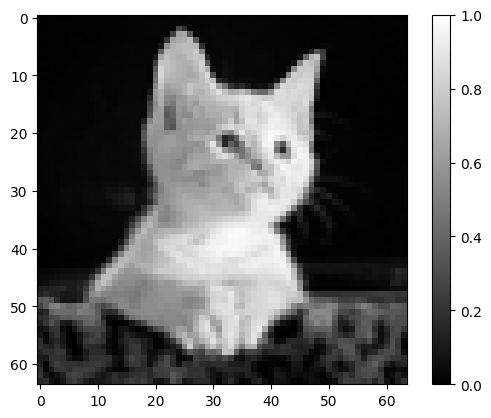

In [25]:
img = Image.open('/content/drive/MyDrive/STSIVA 2025/test_img.png')
img = img.resize((64, 64))
img = img.convert('L')
img = np.array(img)
img = torch.tensor(img).float()
img = (img - img.min()) / (img.max() - img.min())
print(img.min(), img.max())
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

In [26]:
img.shape

torch.Size([64, 64])

# **E2E creation example**

In [27]:
class E2E(nn.Module):
    def __init__(self, pinv:bool=False, num_measurements:int=100, img_size:tuple=(128,128), trainable:bool=True, num_channels:int=1):
        super(E2E, self).__init__()
        self.spc = SPC(pinv, num_measurements, img_size, trainable)
        self.unet = UNet(num_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_hat = self.spc(x)
        x_hat = self.unet(x_hat)
        return x_hat

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = E2E(pinv=False, num_measurements=4000, img_size=(64, 64), trainable=True, num_channels=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [42]:
num_epochs = 2000

def visualize_progress(model, img):
    model.eval()
    with torch.no_grad():
      inputs = img.unsqueeze(0).unsqueeze(0).to(device)
      outputs = model(inputs)

      # Display the input, upsampled, and output images
      fig, axs = plt.subplots(1, 2, figsize=(15, 5))
      axs[0].imshow(inputs.squeeze().cpu(), cmap='gray')
      axs[0].set_title('Low-resolution Image')
      axs[1].imshow(outputs.squeeze().cpu(), cmap='gray')
      axs[1].set_title('High-resolution Image'
      plt.show()

c = 0
model.train()
ssim_val = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
psnr_val = PeakSignalNoiseRatio(data_range=1.0).to(device)
inputs = img.unsqueeze(0).unsqueeze(0).to(device)
for epoch in range(num_epochs):
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Train - Epoch [{epoch+1}/{num_epochs}], Step [{c+1}/{1}], Loss: {loss.item():.4f}')
    c += 1

    # Validation
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    with torch.no_grad():
      outputs = model(inputs)
      loss = criterion(outputs, inputs)
      ssim_val(outputs, inputs)
      psnr_val(outputs, inputs)
      mse_val = torch.mean((outputs-inputs)**2)
      ssim_total += ssim_val
      psnr_total += psnr_val
      mse_total += mse_val

    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], SSIM: {ssim_total.compute()/1:.4f}, PSNR: {psnr_total.compute()/1:.4f}, MSE: {mse_total/1:.4f}')

    #if (epoch + 1) % 10 == 0:
    #    visualize_progress(model, img)

Train - Epoch [1/2000], Step [1/1], Loss: 0.7457
Validation - Epoch [1/2000], SSIM: -0.1860, PSNR: 6.7926, MSE: 0.2093
Train - Epoch [2/2000], Step [2/1], Loss: 0.2093
Validation - Epoch [2/2000], SSIM: -0.1890, PSNR: 6.8739, MSE: 0.2015
Train - Epoch [3/2000], Step [3/1], Loss: 0.2015
Validation - Epoch [3/2000], SSIM: -0.1894, PSNR: 6.9637, MSE: 0.1928
Train - Epoch [4/2000], Step [4/1], Loss: 0.1928
Validation - Epoch [4/2000], SSIM: -0.1816, PSNR: 7.0694, MSE: 0.1819
Train - Epoch [5/2000], Step [5/1], Loss: 0.1819
Validation - Epoch [5/2000], SSIM: -0.1520, PSNR: 7.1973, MSE: 0.1679
Train - Epoch [6/2000], Step [6/1], Loss: 0.1679
Validation - Epoch [6/2000], SSIM: -0.0855, PSNR: 7.3605, MSE: 0.1485
Train - Epoch [7/2000], Step [7/1], Loss: 0.1485
Validation - Epoch [7/2000], SSIM: -0.0268, PSNR: 7.5626, MSE: 0.1252
Train - Epoch [8/2000], Step [8/1], Loss: 0.1252
Validation - Epoch [8/2000], SSIM: 0.0138, PSNR: 7.8065, MSE: 0.0987
Train - Epoch [9/2000], Step [9/1], Loss: 0.0987


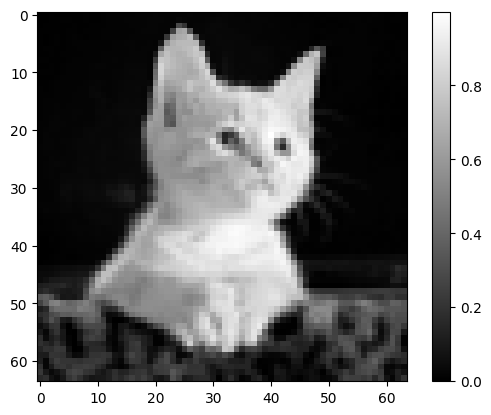

In [43]:
# Results are bad because the model (SPC coded aperture + UNet weights) is not trained yet
plt.imshow(outputs.squeeze().squeeze().cpu().detach(), cmap='gray')
plt.colorbar()
plt.show()

## Note:
Results are not good, because the coded apertures from the SPC layer and the U-Net have not been trained yet.